In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import copy
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.python.training.tracking import base as trackable
# from tensorflow.python.keras.engine import data_adapter
# from tensorflow.python.eager import backprop
from functools import partial
# from tensorflow.python.keras.engine.training import _minimize
# import tensorflow_addons as tfa
import math
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from sklearn.manifold import TSNE

2022-05-11 11:34:57.092046: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

2022-05-11 11:34:59.108513: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-11 11:34:59.109476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-11 11:34:59.198199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:48:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-05-11 11:34:59.198234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-11 11:34:59.200232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-11 11:34:59.200282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

# Load Data

In [3]:
n_class = 10
train_set_size = 12406
test_set_size = 10000
valid_size_per_class = 5

valid_set_size = valid_size_per_class * n_class



def decode(instance):
    feature_spec = {
    'image/encoded': tf.io.FixedLenFeature((), tf.string),
    'image/class/label': tf.io.FixedLenFeature((), tf.int64)
    }
    instance = tf.io.parse_example(instance, feature_spec)
    image = tf.io.decode_raw(instance["image/encoded"], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [32, 32, 3])
    label = instance["image/class/label"]
    label = tf.cast(label, tf.float32)
    return image, label

traing_dateset = tf.data.TFRecordDataset("./data/cifar10-lt_train.tfrecord").map(decode)

train_x, train_y = np.zeros([train_set_size, 32, 32, 3]), np.zeros([train_set_size])
for i,instance in enumerate(traing_dateset.as_numpy_iterator()):
    train_x[i] = instance[0]
    train_y[i] = instance[1]

valid_x, valid_y = np.zeros([valid_set_size,32,32,3]), np.zeros([valid_set_size])

train_set_size_no_valid = train_set_size - valid_set_size
train_x_no_valid = train_x
train_y_no_valid = train_y

train_size_no_valid_per_class = np.zeros([n_class])

for i in range(n_class):
    indices_of_instances = np.where(train_y_no_valid == i)[0]
    train_size_no_valid_per_class[i] = len(indices_of_instances) - valid_size_per_class
    
    np.random.seed(i)
    np.random.shuffle(indices_of_instances)
    
    indices_of_valid_instances = indices_of_instances[ : valid_size_per_class]
    valid_x[i * valid_size_per_class : (i+1) * valid_size_per_class] = \
        train_x_no_valid[indices_of_valid_instances]
    
    valid_y[i * valid_size_per_class : (i+1) * valid_size_per_class] = \
        train_y_no_valid[indices_of_valid_instances]
    
    train_x_no_valid = np.delete(train_x_no_valid, indices_of_valid_instances, 0)
    train_y_no_valid = np.delete(train_y_no_valid, indices_of_valid_instances, 0)

    
test_dateset = tf.data.TFRecordDataset("./data/cifar10_test.tfrecord").map(decode)

test_x, test_y = np.zeros([test_set_size, 32, 32, 3]), np.zeros([test_set_size])
for i,instance in enumerate(test_dateset.as_numpy_iterator()):
    test_x[i] = instance[0]
    test_y[i] = instance[1]
    

2022-05-11 11:34:59.227024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-11 11:34:59.238219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:48:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-05-11 11:34:59.238263: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-11 11:34:59.238298: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-11 11:34:59.238308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-05-11 11:34:59.238319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-05-11 11:34:59.238329: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcura

In [4]:
# import sys
print('training set size:',train_x_no_valid.__sizeof__())
print('test set size:',test_x.__sizeof__())

training set size: 303661208
test set size: 245760152


In [5]:
normalize_x = lambda x: x/255 - 0.5

train_x_no_valid = tf.constant(normalize_x(train_x_no_valid))
test_x = tf.constant(normalize_x(test_x))
valid_x = tf.constant(normalize_x(valid_x))

In [6]:
train_y_no_valid = tf.constant(keras.utils.to_categorical(train_y_no_valid, n_class))
test_y = tf.constant(keras.utils.to_categorical(test_y, n_class))
valid_y = tf.constant(keras.utils.to_categorical(valid_y, n_class))

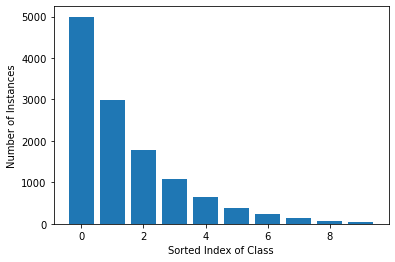

In [7]:
plt.bar(range(len(train_size_no_valid_per_class)), train_size_no_valid_per_class)
plt.ylabel('Number of Instances')
plt.xlabel('Sorted Index of Class')
plt.show()

In [8]:
padding = 4

# @trackable.no_automatic_dependency_tracking 
def train_generator(epochs, batch_size, encoding_matrix):
    def preprocess_data(x, y):
        x = tf.image.resize_with_crop_or_pad(x, 32 + padding, 32 + padding)
        x = tf.image.random_crop(x, [32, 32, 3])
        x = tf.image.random_flip_left_right(x)
        return x, y

    
    for epoch in range(epochs):

        y = tf.matmul(train_y_no_valid, encoding_matrix)
    
        train_dataset = tf.data.Dataset.from_tensor_slices((train_x_no_valid, y)
        ).map(
            preprocess_data
        ).shuffle(
            train_set_size, epoch
        ).batch(
            batch_size
        ).prefetch(
            tf.data.experimental.AUTOTUNE
        )
    
        for batch in train_dataset:
            yield batch

# Loss

In [9]:
# focal loss 
def focal(gamma=2.):
    def focal_loss (y_true, y_pred):
        ep = 1e-7
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = y_pred + (1. - 2.*y_pred) * ep
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.reduce_sum(-y_true*((1-y_pred)**gamma)*tf.math.log(y_pred), axis=1)
    
    return focal_loss


In [10]:
loss_key = 'ce'
focal_gamma = 1.
loss_fn_dic = {'focal':focal(focal_gamma), 
               'ce':keras.losses.categorical_crossentropy,
               'mse':keras.losses.mean_squared_error}
loss_fn = loss_fn_dic[loss_key]

# Callbacks

In [11]:
evaluation_batch_size = 5000

class UpdateEncodingMatrixAndGetMetrics_EEC (keras.callbacks.Callback):
    @trackable.no_automatic_dependency_tracking 
    def __init__(self, 
                 beginEncodingEpoch,endEncodingEpoch, 
                 codingEnhancementRate, mu, 
                 trainSet_x, trainSet_y, 
                 validSet_x, validSet_y,
                 trainMetrics, validMetrics,
                 keyWord):
        super().__init__()
        self.beginEncodingEpoch = beginEncodingEpoch
        self.endEncodingEpoch = endEncodingEpoch
        self.codingEnhancementRate = tf.constant(codingEnhancementRate)
        self.trainSet_x = trainSet_x
        self.trainSet_y = trainSet_y
        self.validSet_x = validSet_x
        self.validSet_y = validSet_y
        self.trainMetrics = trainMetrics
        self.validMetrics = validMetrics
        self.mu = mu
        self.keyWord = keyWord

    
    @trackable.no_automatic_dependency_tracking 
    def _confusion_matrix(self, labels, preds):
        pred_classes = tf.one_hot(tf.argmax(preds, axis=1), 10)
        cm=tf.matmul(labels, pred_classes, transpose_a=True)
        cm=cm/tf.reduce_sum(cm, axis=1, keepdims=True)
        return cm


    @trackable.no_automatic_dependency_tracking 
    def _soft_confusion_matrix(self, labels, preds):
        scm=tf.matmul(labels, preds, transpose_a=True)
        scm=scm/tf.reduce_sum(scm, axis=1, keepdims=True)
        return scm


    @trackable.no_automatic_dependency_tracking
    def _make_encoding_matrix(self, confusionMatrix):
        coSenMatrix =  confusionMatrix - tf.eye(10)
        encodingMatrix = - self.codingEnhancementRate \
                            * coSenMatrix \
                            + tf.eye(10)
        
        return encodingMatrix


    @trackable.no_automatic_dependency_tracking 
    def on_train_begin(self, logs):
        if self.endEncodingEpoch <= 0 or self.beginEncodingEpoch > 0:
            encodingMatrix = tf.eye(10)
        else:
            y_h = tf.constant(self.model.predict(self.validSet_x, batch_size=evaluation_batch_size, verbose=0))
            y = self.validSet_y
            scm = self._soft_confusion_matrix(y, y_h)
            encodingMatrix = ((1-self.mu) * encoding_matrix +
                              self.mu * self._make_encoding_matrix(scm))
        K.set_value(encoding_matrix, encodingMatrix)

   
    @trackable.no_automatic_dependency_tracking
    def on_epoch_begin(self, epoch, logs):
        print('\n'+self.keyWord)
        

    @trackable.no_automatic_dependency_tracking
    def on_epoch_end(self, epoch, logs):
        y_h = tf.constant(self.model.predict(self.trainSet_x, batch_size=evaluation_batch_size, verbose=0))
        y = self.trainSet_y
        self.trainMetrics[0][epoch] = self._soft_confusion_matrix(y, y_h).numpy()
        self.trainMetrics[1][epoch] = self._confusion_matrix(y, y_h).numpy()
        self.trainMetrics[2][epoch] = tf.reduce_mean(loss_fn(y, y_h)).numpy()
        self.trainMetrics[3][epoch] = tf.reduce_mean(keras.metrics.categorical_accuracy(y, y_h)).numpy()
        self.trainMetrics[4][epoch] = metrics.roc_auc_score(y.numpy(), y_h.numpy(), multi_class='ovr')

        print('\nTest on train set:',
              'loss=', self.trainMetrics[2][epoch],
              'acc=', self.trainMetrics[3][epoch],
              'auc=', self.trainMetrics[4][epoch] )

        y_h = tf.constant(self.model.predict(self.validSet_x, batch_size=evaluation_batch_size, verbose=0))
        y = self.validSet_y
        scm = self._soft_confusion_matrix(y, y_h)
        self.validMetrics[0][epoch] = scm.numpy()
        self.validMetrics[1][epoch] = tf.reduce_mean(loss_fn(y, y_h)).numpy()
        self.validMetrics[2][epoch] = scm.numpy().diagonal().mean()
        self.validMetrics[3][epoch] = metrics.roc_auc_score(y.numpy(), y_h.numpy(), multi_class='ovr')

        print('Test on valid set:',
            'loss=', self.validMetrics[1][epoch],
            'acc=', self.validMetrics[2][epoch],
            'auc=', self.validMetrics[3][epoch] )

        if epoch+1 < self.endEncodingEpoch and epoch+1>=self.beginEncodingEpoch:
            new_encoding_matrix = (1-self.mu) * encoding_matrix + \
                              self.mu * self._make_encoding_matrix(scm)
            K.set_value(encoding_matrix, new_encoding_matrix)

        elif epoch+1 == self.endEncodingEpoch:
            K.set_value(encoding_matrix, tf.eye(10))
            
        print()
        
        
        
    @trackable.no_automatic_dependency_tracking
    def on_train_end(self, logs):
        K.set_value(encoding_matrix, tf.eye(10))
        print('*'*100)
        print('*'*100)
        print('*'*100)


####################################################################################
class UpdateEncodingMatrixAndGetMetrics_Base (UpdateEncodingMatrixAndGetMetrics_EEC):
    @trackable.no_automatic_dependency_tracking 
    def __init__(self, 
                 trainSet_x, trainSet_y, 
                 validSet_x, validSet_y,
                 trainMetrics, validMetrics,
                 keyWord):
        super(UpdateEncodingMatrixAndGetMetrics_EEC, self).__init__()
        self.trainSet_x = trainSet_x
        self.trainSet_y = trainSet_y
        self.validSet_x = validSet_x
        self.validSet_y = validSet_y
        self.trainMetrics = trainMetrics
        self.validMetrics = validMetrics
        self.keyWord = keyWord

   
    @trackable.no_automatic_dependency_tracking
    def _make_encoding_matrix(self):
        return



    @trackable.no_automatic_dependency_tracking 
    def on_train_begin(self, logs):
        super(UpdateEncodingMatrixAndGetMetrics_EEC, self).on_train_begin(logs)


    @trackable.no_automatic_dependency_tracking
    def on_epoch_end(self, epoch, logs):
        y_h = tf.constant(self.model.predict(self.trainSet_x, batch_size=evaluation_batch_size, verbose=0))
        y = self.trainSet_y
        self.trainMetrics[0][epoch] = self._soft_confusion_matrix(y, y_h).numpy()
        self.trainMetrics[1][epoch] = self._confusion_matrix(y, y_h).numpy()
        self.trainMetrics[2][epoch] = tf.reduce_mean(loss_fn(y, y_h)).numpy()
        self.trainMetrics[3][epoch] = tf.reduce_mean(keras.metrics.categorical_accuracy(y, y_h)).numpy()
        self.trainMetrics[4][epoch] = metrics.roc_auc_score(y.numpy(), y_h.numpy(), multi_class='ovr')

        print('\nTest on train set:',
            'loss=', self.trainMetrics[2][epoch],
            'acc=', self.trainMetrics[3][epoch],
            'auc=', self.trainMetrics[4][epoch] )

        y_h = tf.constant(self.model.predict(self.validSet_x, batch_size=evaluation_batch_size, verbose=0))
        y = self.validSet_y
        scm = self._soft_confusion_matrix(y, y_h)
        self.validMetrics[0][epoch] = scm.numpy()
        self.validMetrics[1][epoch] = tf.reduce_mean(loss_fn(y, y_h)).numpy()
        self.validMetrics[2][epoch] = scm.numpy().diagonal().mean()
        self.validMetrics[3][epoch] = metrics.roc_auc_score(y.numpy(), y_h.numpy(), multi_class='ovr')
        
        print('Test on valid set:',
            'loss=', self.validMetrics[1][epoch],
            'acc=', self.validMetrics[2][epoch],
            'auc=', self.validMetrics[3][epoch] )

        print()

        
        
#################################################################################################################        
class UpdateEncodingMatrixAndGetMetrics_Reweight (UpdateEncodingMatrixAndGetMetrics_EEC):
    @trackable.no_automatic_dependency_tracking 
    def _make_encoding_matrix(self, confusionMatrix):
        CoSenMatrix =  confusionMatrix - tf.eye(10)
        encodingMatrix = - self.codingEnhancementRate \
                            * CoSenMatrix \
                            + tf.eye(10)
        encodingMatrix = encodingMatrix * tf.eye(10)
        return encodingMatrix        

#################################################################################################################        
class UpdateEncodingMatrixAndGetMetrics_CoSen (UpdateEncodingMatrixAndGetMetrics_EEC):
    @trackable.no_automatic_dependency_tracking 
    def _make_encoding_matrix(self, confusionMatrix):
        CoSenMatrix =  (1 - tf.eye(10))*(confusionMatrix - tf.eye(10))
        encodingMatrix = - self.codingEnhancementRate \
                            * CoSenMatrix \
                            + tf.eye(10)
        return encodingMatrix     
    
##################################################################################################################
class AdjustLR (keras.callbacks.Callback):
    def __init__(self, schedule, base_learning_rate = None):
        super().__init__()
        self._schedule = schedule
        self._base_learning_rate = base_learning_rate

    def on_epoch_begin(self, epoch, logs):
        warmup_lr_multiplier, warmup_end_epoch = self._schedule[0]
        learning_rate = (
            self._base_learning_rate * warmup_lr_multiplier * (epoch+1) /
            (warmup_end_epoch+1))
        for mult, start_epoch in self._schedule:
            learning_rate = tf.where(epoch >= start_epoch,
                                   self._base_learning_rate * mult, learning_rate)

        K.set_value(self.model.optimizer.learning_rate, learning_rate)
        print(self.model.optimizer.learning_rate)

# Build the Model

In [12]:
he_normal = keras.initializers.HeUniform()
glorot_normal = keras.initializers.GlorotNormal()
he_uniform = keras.initializers.HeUniform()
glorot_uniform = keras.initializers.GlorotUniform()
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False, 
                        kernel_initializer=he_normal)
DefaultBN = partial(keras.layers.BatchNormalization, 
                      momentum=0.9,
                      epsilon=1e-5)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters,kernel_size=1,strides=strides),
            DefaultBN(),
            self.activation,
            DefaultConv2D(filters),
            DefaultBN(),
            self.activation,
            DefaultConv2D(filters,kernel_size=1),
            DefaultBN()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                DefaultBN()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


model = keras.Sequential()
model.add(keras.layers.Input(shape=(32, 32, 3)))
model.add(keras.layers.ZeroPadding2D(padding=(3, 3)))
model.add(DefaultConv2D(16,padding='valid'))
model.add(DefaultBN())
model.add(keras.layers.Activation("relu"))
prev_filters = 16
for filters in [16] * 5 + [32] * 5 + [64] * 5:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(DefaultBN())
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)))
model.add(DefaultBN())
model.add(keras.layers.Softmax())
model.summary()
initialWeights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 16)        432       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 36, 36, 16)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 36, 36, 16)        3008      
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 36, 36, 16)        3008      
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 36, 36, 16)        3

# Optimizer

In [13]:
Optimizer = lambda learning_rate=0.01:keras.optimizers.SGD(learning_rate = learning_rate, 
                                                          momentum=0.9,  
                                                          nesterov=True)

# Find Learning Rate

2022-05-11 11:35:09.513959: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-11 11:35:09.785096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


97/97 [==============================] - 7s 26ms/step - loss: 2.3094


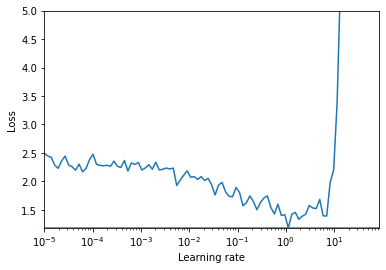

In [14]:
optimizer = Optimizer()
model.compile(optimizer=optimizer, loss = loss_fn)
model.set_weights(initialWeights)
        
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)        
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=100):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), 5.0])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

    
batch_size = 128
rates, losses = find_learning_rate(model, train_x_no_valid, train_y_no_valid, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

# Train the Model

In [15]:
lrDic = {'focal':0.5,
         'ce':0.1,
         'mse':5.0
        }
lr = lrDic[loss_key]
codingEnhancementRateDic = {'focal':0.5,
                            'ce':1.0,
                            'mse':0.5
                           }
codingEnhancementRate = codingEnhancementRateDic[loss_key]

lr_schedule_dic = {'focal':[(1.0, 5), (0.1, 200), (0.01, 300)],
                   'ce':[(1.0, 5), (0.1, 200), (0.01, 250)],
                   'mse':[(1.0, 5), (0.1, 200), (0.01, 300)]}

lr_schedule = lr_schedule_dic[loss_key]

mu = 0.1 if loss_key == "mse" else 0.5  #update rate

epochs_dic = {'focal':400,
          'ce':300,
          'mse':400} 
epochs = epochs_dic[loss_key]
endEncodingEpoch = epochs
beginEncodingEpoch = 0
batch_size = 128
steps = math.ceil(train_set_size_no_valid / batch_size) 
print(steps)

if 'softConfusionMatrix_train' not in locals() or len(softConfusionMatrix_train[0]) != epochs:
    softConfusionMatrix_train = np.zeros((4, epochs, n_class, n_class))
    confusionMatrix_train = np.zeros((4, epochs, n_class, n_class))
    loss_train=np.zeros((4,epochs))
    acc_train=np.zeros((4,epochs))
    auc_train=np.zeros((4,epochs))
    
    softConfusionMatrix_valid = np.zeros((4, epochs, n_class, n_class))
    loss_valid=np.zeros((4,epochs))
    acc_valid=np.zeros((4,epochs))
    auc_valid=np.zeros((4,epochs))

model_weights = [] 


# Pretrain-------------------------------------------------------------------------
tf.compat.v1.reset_default_graph()
encoding_matrix = tf.Variable(tf.eye(10), trainable=False)
trainGen = train_generator(epochs, batch_size, encoding_matrix)
model.set_weights(initialWeights)
optimizer = Optimizer(lr)
model.compile(optimizer=optimizer, loss = loss_fn)

metric_idx = 0
trainMetrics = (softConfusionMatrix_train[metric_idx], 
                confusionMatrix_train[metric_idx],loss_train[metric_idx], 
                acc_train[metric_idx], auc_train[metric_idx])

validMetrics = (softConfusionMatrix_valid[metric_idx], 
                loss_valid[metric_idx], acc_valid[metric_idx], auc_valid[metric_idx])

adjust_lr = AdjustLR(
      schedule = lr_schedule,
      base_learning_rate = lr,
  )

uemgm = UpdateEncodingMatrixAndGetMetrics_Base(train_x_no_valid, train_y_no_valid,
                                               valid_x, valid_y, trainMetrics, 
                                               validMetrics, 'Pretrain')
                        
_ = model.fit(trainGen, epochs = beginEncodingEpoch, verbose = 2,
                steps_per_epoch = steps, callbacks=[uemgm,
                                             adjust_lr,
                                            ])

pretrainedWeights = model.get_weights()

97
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


## Baseline

In [16]:
tf.compat.v1.reset_default_graph()
encoding_matrix = tf.Variable(tf.eye(10), trainable=False)
trainGen = train_generator(epochs, batch_size, encoding_matrix)
model.set_weights(pretrainedWeights)
model.compile(optimizer=copy.deepcopy(optimizer), loss = loss_fn)

metric_idx = 0
trainMetrics = (softConfusionMatrix_train[metric_idx], 
                confusionMatrix_train[metric_idx],loss_train[metric_idx], 
                acc_train[metric_idx], auc_train[metric_idx])

validMetrics = (softConfusionMatrix_valid[metric_idx], 
                loss_valid[metric_idx], acc_valid[metric_idx], auc_valid[metric_idx])

adjust_lr = AdjustLR(
      schedule = lr_schedule,
      base_learning_rate = lr,
  )

uemgm = UpdateEncodingMatrixAndGetMetrics_Base(train_x_no_valid, train_y_no_valid,
                                               valid_x, valid_y, trainMetrics, 
                                               validMetrics, 'Baseline')
                        
_ = model.fit(trainGen, 
              initial_epoch = beginEncodingEpoch, 
              epochs = epochs, verbose = 2,
              steps_per_epoch = steps, callbacks=[uemgm,
                                             adjust_lr,
                                            ])
baselineWeights = model.get_weights()

Epoch 1/300

Baseline
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.016666668>
97/97 - 5s - loss: 1.5215

Test on train set: loss= 1.2747505903244019 acc= 0.5844933390617371 auc= 0.7405386569012873
Test on valid set: loss= 2.4610650539398193 acc= 0.20691156387329102 auc= 0.7142222222222221

Epoch 2/300

Baseline
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.033333335>
97/97 - 2s - loss: 1.1429

Test on train set: loss= 1.0731741189956665 acc= 0.6341049075126648 auc= 0.8154658638562733
Test on valid set: loss= 2.460397958755493 acc= 0.2263018637895584 auc= 0.7791111111111111

Epoch 3/300

Baseline
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.05>
97/97 - 3s - loss: 1.0247

Test on train set: loss= 0.9596424102783203 acc= 0.6734380125999451 auc= 0.8605473223943545
Test on valid set: loss= 2.476236343383789 acc= 0.23468229174613953 auc= 0.7946666666666665

Epoch 4/300

Baseline
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=

## Enhancement Encoding

In [17]:
tf.compat.v1.reset_default_graph()
encoding_matrix = tf.Variable(tf.eye(10), trainable=False)
trainGen = train_generator(epochs, batch_size, encoding_matrix)
model.set_weights(pretrainedWeights)
model.compile(optimizer=copy.deepcopy(optimizer), loss = loss_fn)

metric_idx = 1
trainMetrics = (softConfusionMatrix_train[metric_idx], 
                confusionMatrix_train[metric_idx],loss_train[metric_idx], 
                acc_train[metric_idx], auc_train[metric_idx])

validMetrics = (softConfusionMatrix_valid[metric_idx], 
                loss_valid[metric_idx], acc_valid[metric_idx], auc_valid[metric_idx])

adjust_lr = AdjustLR(
      schedule = lr_schedule,
      base_learning_rate = lr,
  )

uemgm = UpdateEncodingMatrixAndGetMetrics_EEC(beginEncodingEpoch, endEncodingEpoch,  
                                               codingEnhancementRate, mu,
                                               train_x_no_valid, train_y_no_valid,
                                               valid_x, valid_y, trainMetrics, 
                                               validMetrics, 'Enhancement')
                        
_ = model.fit(trainGen, 
              initial_epoch = beginEncodingEpoch, 
              epochs = epochs, verbose = 2,
              steps_per_epoch = steps, callbacks=[uemgm,
                                             adjust_lr,
                                            ])
enhancementWeights = model.get_weights()

Epoch 1/300

Enhancement
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.016666668>
97/97 - 5s - loss: 1.5090

Test on train set: loss= 1.3514435291290283 acc= 0.5666882395744324 auc= 0.7598766139618284
Test on valid set: loss= 2.7832343578338623 acc= 0.18894359469413757 auc= 0.6786666666666668

Epoch 2/300

Enhancement
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.033333335>
97/97 - 3s - loss: -1.5091e+00

Test on train set: loss= 4.384975910186768 acc= 0.4679507911205292 auc= 0.7018917956450196
Test on valid set: loss= 8.08192253112793 acc= 0.17855356633663177 auc= 0.6564444444444443

Epoch 3/300

Enhancement
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.05>
97/97 - 3s - loss: -3.6232e+00

Test on train set: loss= 3.3237667083740234 acc= 0.5702492594718933 auc= 0.771125702463562
Test on valid set: loss= 8.093157768249512 acc= 0.19782651960849762 auc= 0.67

Epoch 4/300

Enhancement
<tf.Variable 'learning_rate:0' shape=() dtype=float32, 

## Reweight

In [18]:
tf.compat.v1.reset_default_graph()
encoding_matrix = tf.Variable(tf.eye(10), trainable=False)
trainGen = train_generator(epochs, batch_size, encoding_matrix)
model.set_weights(pretrainedWeights)
model.compile(optimizer=copy.deepcopy(optimizer), loss = loss_fn)

metric_idx = 2
trainMetrics = (softConfusionMatrix_train[metric_idx], 
                confusionMatrix_train[metric_idx],loss_train[metric_idx], 
                acc_train[metric_idx], auc_train[metric_idx])

validMetrics = (softConfusionMatrix_valid[metric_idx], 
                loss_valid[metric_idx], acc_valid[metric_idx], auc_valid[metric_idx])

adjust_lr = AdjustLR(
      schedule = lr_schedule,
      base_learning_rate = lr,
  )

uemgm = UpdateEncodingMatrixAndGetMetrics_Reweight(beginEncodingEpoch, endEncodingEpoch,  
                                               codingEnhancementRate, mu,
                                               train_x_no_valid, train_y_no_valid,
                                               valid_x, valid_y, trainMetrics, 
                                               validMetrics, 'Reweight')
                        
_ = model.fit(trainGen, 
              initial_epoch = beginEncodingEpoch, 
              epochs = epochs, verbose = 2,
              steps_per_epoch = steps, callbacks=[uemgm,
                                             adjust_lr,
                                            ])
reweightWeights = model.get_weights()

Epoch 1/300

Reweight
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.016666668>
97/97 - 6s - loss: 1.5189

Test on train set: loss= 1.1770888566970825 acc= 0.6104726195335388 auc= 0.7724332118747087
Test on valid set: loss= 2.495112657546997 acc= 0.18380489945411682 auc= 0.6853333333333333

Epoch 2/300

Reweight
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.033333335>
97/97 - 3s - loss: 1.7737

Test on train set: loss= 4.278204441070557 acc= 0.41777274012565613 auc= 0.7205668161369653
Test on valid set: loss= 6.752689361572266 acc= 0.19360317289829254 auc= 0.624

Epoch 3/300

Reweight
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.05>
97/97 - 3s - loss: 2.4742

Test on train set: loss= 2.099769115447998 acc= 0.5994658470153809 auc= 0.7957465541425364
Test on valid set: loss= 6.467487812042236 acc= 0.2906305193901062 auc= 0.7408888888888889

Epoch 4/300

Reweight
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.06666667>
97/

## CoSen

In [19]:
tf.compat.v1.reset_default_graph()
encoding_matrix = tf.Variable(tf.eye(10), trainable=False)
trainGen = train_generator(epochs, batch_size, encoding_matrix)
model.set_weights(pretrainedWeights)
model.compile(optimizer=copy.deepcopy(optimizer), loss = loss_fn)


metric_idx = 3
trainMetrics = (softConfusionMatrix_train[metric_idx], 
                confusionMatrix_train[metric_idx],loss_train[metric_idx], 
                acc_train[metric_idx], auc_train[metric_idx])

validMetrics = (softConfusionMatrix_valid[metric_idx], 
                loss_valid[metric_idx], acc_valid[metric_idx], auc_valid[metric_idx])

adjust_lr = AdjustLR(
      schedule = lr_schedule,
      base_learning_rate = lr,
  )

uemgm = UpdateEncodingMatrixAndGetMetrics_CoSen(beginEncodingEpoch, endEncodingEpoch,  
                                               codingEnhancementRate, mu,
                                               train_x_no_valid, train_y_no_valid,
                                               valid_x, valid_y, trainMetrics, 
                                               validMetrics, 'CoSen')
_ = model.fit(trainGen, 
              initial_epoch = beginEncodingEpoch, 
              epochs = epochs, verbose = 2,
              steps_per_epoch = steps, callbacks=[uemgm,
                                             adjust_lr,
                                            ])

cosenWeights = model.get_weights()

Epoch 1/300

CoSen
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.016666668>
97/97 - 5s - loss: 1.5530

Test on train set: loss= 1.3484238386154175 acc= 0.5787471532821655 auc= 0.7724083859897146
Test on valid set: loss= 2.777120590209961 acc= 0.19578734040260315 auc= 0.6982222222222222

Epoch 2/300

CoSen
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.033333335>
97/97 - 3s - loss: -1.0854e+00

Test on train set: loss= 1.0714298486709595 acc= 0.6390417814254761 auc= 0.8135939240623478
Test on valid set: loss= 3.0231456756591797 acc= 0.24761533737182617 auc= 0.7542222222222221

Epoch 3/300

CoSen
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.05>
97/97 - 2s - loss: -1.2396e+00

Test on train set: loss= 1.131277322769165 acc= 0.6381515264511108 auc= 0.7689231862655844
Test on valid set: loss= 3.423051118850708 acc= 0.2613378167152405 auc= 0.6804444444444445

Epoch 4/300

CoSen
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0

# Print and Plot the Metrics

In [20]:
def confusion_matrix(labels, preds):
    pred_classes = tf.one_hot(tf.argmax(preds, axis=1), 10)
    cm=tf.matmul(labels, pred_classes, transpose_a=True)
    cm=cm/tf.reduce_sum(cm, axis=1, keepdims=True)
    return cm

def soft_confusion_matrix(labels, preds):
    scm=tf.matmul(labels, preds, transpose_a=True)
    scm=scm/tf.reduce_sum(scm, axis=1, keepdims=True)
    return scm

softConfusionMatrix_test = np.zeros((4, n_class, n_class))
confusionMatrix_test = np.zeros((4, n_class, n_class))
loss_test=np.zeros((4,))
acc_test=np.zeros((4,))
auc_test=np.zeros((4,))
minority_acc_test=np.zeros((4,))
experiment_keywords=['baseline', 'enhencement encoding', 'reweighting', 'cost-sensitiveness']
weight_list = [baselineWeights, enhancementWeights, reweightWeights, cosenWeights]

n_minority_class = 5
minority_class_beging_idx = n_class - n_minority_class


for metric_idx in range(4):
    model.set_weights(weight_list[metric_idx])
    y_h = tf.constant(model.predict(test_x, batch_size=evaluation_batch_size, verbose=0))
    y = test_y
    softConfusionMatrix_test[metric_idx] = soft_confusion_matrix(y, y_h).numpy()
    confusionMatrix_test[metric_idx] = confusion_matrix(y, y_h).numpy()
    loss_test[metric_idx] = tf.reduce_mean(loss_fn(y, y_h)).numpy()
    acc_test[metric_idx] = tf.reduce_mean(keras.metrics.categorical_accuracy(y, y_h)).numpy()
    auc_test[metric_idx] = metrics.roc_auc_score(y.numpy(), y_h.numpy(), multi_class='ovr')
    minority_acc_test[metric_idx] = confusionMatrix_test[metric_idx,
                                                         minority_class_beging_idx:,
                                                         minority_class_beging_idx:].diagonal().mean()


for k,a,ma in zip(experiment_keywords,acc_test, minority_acc_test):
    print('test accuracy of '+k+':', a)
    print('minority accuracy of '+k+':', ma)
    print()
    

test accuracy of baseline: 0.6437000036239624
minority accuracy of baseline: 0.46419999599456785

test accuracy of enhencement encoding: 0.6942999958992004
minority accuracy of enhencement encoding: 0.5388000011444092

test accuracy of reweighting: 0.6883000135421753
minority accuracy of reweighting: 0.519599997997284

test accuracy of cost-sensitiveness: 0.6686999797821045
minority accuracy of cost-sensitiveness: 0.5154000103473664



## Show the Soft-Confusion Matrices 

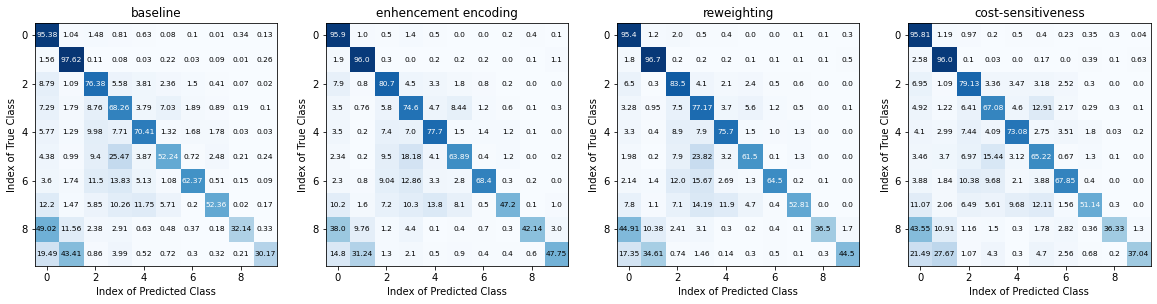

In [21]:
plt.figure(figsize = [20,5])

for scm_idx in range(4):
    scm = softConfusionMatrix_test[scm_idx] * 100
    plt.subplot(1,4,scm_idx+1)
    plt.imshow(scm, cmap = 'Blues', vmax = 100, vmin = 0)

    for i in range(10):
        for j in range(10):
            z = np.around(scm[i, j],2)
            c = 'k' if z<50 else 'w'
            text = plt.text(j, i, z,
                           ha="center", va="center", size = 7.5,
                           color = c
                           )
            
    plt.ylabel('Index of True Class')
    plt.xlabel('Index of Predicted Class')
    plt.title(experiment_keywords[scm_idx])


plt.show()

## T-SNE

/root/anaconda3/envs/xxx/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/root/anaconda3/envs/xxx/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/root/anaconda3/envs/xxx/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/root/anaconda3/envs/xxx/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better co

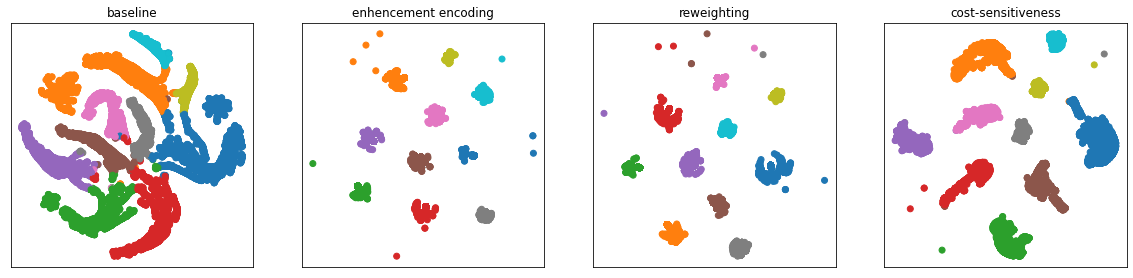

In [22]:
plt.figure(figsize = [20,4.5])

for tsne_idx in range(4):
    model.set_weights(weight_list[tsne_idx])
    y_h = model.predict(test_x, batch_size=evaluation_batch_size, verbose=0)
    predictions = np.argmax(y_h, axis = 1)
    ts = TSNE(init= 'pca', learning_rate = 'auto')
    results = ts.fit_transform(y_h)
    x_min, x_max = np.min(results[:,0]), np.max(results[:,0])
    y_min, y_max = np.min(results[:,1]), np.max(results[:,1])
    x = (results[:,0] - x_min) / (x_max - x_min)
    y = (results[:,1] - y_min) / (y_max - y_min)
    plt.subplot(1,4,tsne_idx+1)  
    plt.scatter(x, y, c = ['C'+str(p) for p in predictions])
    plt.xticks([])        
    plt.yticks([])
    plt.title(experiment_keywords[tsne_idx])

plt.show()
